In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
import imblearn
warnings.filterwarnings('ignore')

%matplotlib inline

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.metrics import classification_report,confusion_matrix,recall_score,precision_score,accuracy_score,f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils import resample

# PROBLEM STATEMENT
    Masalah ini didasarkan pada sektor Perbankan dimana bank ingin memprediksi Churn(perpindahan) pelanggan berdasarkan pada historical data dari pelanggan. Yang dimaksud dengan churn adalah bank ingin memprediksi apakah nasabah akan berpindah atau tidak.
<br>

    Bank ingin menjaga retensi nasabah untuk produknya: rekening tabungan. Yang menjadi fokus pada penelitian adalah nasabah yang memiliki nilai churn 1, yang artinya menurut historical data, nasabah tersebut akan berpindah ke bank lain(churn). Mengapa ini penting dilakukan, karena menarik pelanggan baru jauh lebih mahal bagi mereka daripada menahan pelanggan lama, selain itu kehilangan pelanggan lama menyebabkan bank kehilangan keuntungan, sehingga dengan dilakukan CHURN PREDICTION ini, bisa membantu kita untuk mengetahui nasabah yang kemungkinan pada kuartal berikutnya akan berpindah bank, sehingga dapat dilakukan antisipasi(promosi menarik, service/pelayanan yang lebih baik, dan lain-lain)
    

# GOALS
    1. Membantu bank untuk memprediksi nasabah yang kemungkinan akan keluar, sehingga dapat dilakukan antisipasi agar mengurangi kemungkinan nasabah keluar.
    2. Fokus pada menurunkan False Negative pada Confusion Matrix pada saat melakukan pembentukan model dengan Machine Learning, sehingga nilai Recall akan menjadi patokan. Menagapa fokus pada False Negative ? Karena untuk False Negative adalah nasabah yang aktualnya akan berpindah bank(1/churn) namun model memprediksinya sebagai tetap pada bank kita(0/tidak churn), maka secara tidak langsung akan ada kemungkinan kita kehilangan 1 pelanggan karena model memprediksi salah.

# Feature Description
    - X :
        1. customer_id ==> id dari customer
        2. vintage ==> sudah berapa lama customer ada di bank tersebut (dalam satuan hari)
        3. age ==> usia customer
        4. gender ==> gender customer
        5. dependents ==> jumlah tanggungan nasabah
        6. occupation ==> pekerjaan/cara nasabah mendapatkan penghasilan
        7. city ==> kode kota customer
        8. customer_nw_category ==> kekayaan bersih customer :
            - 3 : Low
            - 2 : Medium
            - 1 : High
        9. branch_code ==> kode kantor cabang bank dimana customer membuka akun mereka
        10. days_since_last_transaction ==> transaksi terakhir yang dilakukan dalam kurun waktu 1 tahun belakangan (dalam satuan hari)
        11. current_balance ==> saldo customer (per hari ini)
        12. previous_month_end_balance ==> saldo customer bulan lalu
        13. average_monthly_balance_prevQ ==> rata-rata saldo bulanan customer dari quarter sebelumnya.
        14. average_monthly_balance_prevQ2 ==> rata-rata saldo bulanan customer dari 2 quarter sebelumnya.
        15. current_month_credit ==> cash out bulan ini.
        16. previous_month_credit ==> cash out bulan lalu.
        17. current_month_debit ==> cash in bulan ini.
        18. previous_month_debit ==> cash in bulan lalu.
        19. current_month_balance ==> rata-rata saldo ( tabungan/balance) customer pada bulan ini
        20. previous_month_balance ==> rata-rata saldo ( tabungan/balance) customer pada bulan lalu
    - Y(TARGET) :
        1. churn ==> movement of customer from one company to other. 1 : churn , 0 : not churn

# IMPORT DATA

In [129]:
df = pd.read_csv("./Datasets/churn_prediction.csv")
pd.options.display.max_columns = 21
df.head()

,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,days_since_last_transaction,current_balance,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn
0,1,3135,66,Male,0.0,self_employed,187.0,2,755,224.0,1458.71,1458.71,1458.71,1449.07,0.20,0.20,0.20,0.20,1458.71,1458.71,0
1,2,310,35,Male,0.0,self_employed,NaN,2,3214,60.0,5390.37,8704.66,7799.26,12419.41,0.56,0.56,5486.27,100.56,6496.78,8787.61,0
2,4,2356,31,Male,0.0,salaried,146.0,2,41,NaN,3913.16,5815.29,4910.17,2815.94,0.61,0.61,6046.73,259.23,5006.28,5070.14,0
3,5,478,90,NaN,NaN,self_employed,1020.0,2,582,147.0,2291.91,2291.91,2084.54,1006.54,0.47,0.47,0.47,2143.33,2291.91,1669.79,1
4,6,2531,42,Male,2.0,self_employed,1494.0,3,388,58.0,927.72,1401.72,1643.31,1871.12,0.33,714.61,588.62,1538.06,1157.15,1677.16,1


# DESCRIBE DATA

In [130]:
df.info()
## Dapat dilihat untuk masing-masing feature tipenya sudah benar
## kemungkinan akan diubah apabila binning atau encode diperlukan

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28382 entries, 0 to 28381
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   customer_id                     28382 non-null  int64  
 1   vintage                         28382 non-null  int64  
 2   age                             28382 non-null  int64  
 3   gender                          27857 non-null  object 
 4   dependents                      25919 non-null  float64
 5   occupation                      28302 non-null  object 
 6   city                            27579 non-null  float64
 7   customer_nw_category            28382 non-null  int64  
 8   branch_code                     28382 non-null  int64  
 9   days_since_last_transaction     25159 non-null  float64
 10  current_balance                 28382 non-null  float64
 11  previous_month_end_balance      28382 non-null  float64
 12  average_monthly_balance_prevQ   

In [131]:
df.isna().sum()
## terlihat ada beberapa kolom yang terdapat missing values

customer_id                          0
vintage                              0
age                                  0
gender                             525
dependents                        2463
occupation                          80
city                               803
customer_nw_category                 0
branch_code                          0
days_since_last_transaction       3223
current_balance                      0
previous_month_end_balance           0
average_monthly_balance_prevQ        0
average_monthly_balance_prevQ2       0
current_month_credit                 0
previous_month_credit                0
current_month_debit                  0
previous_month_debit                 0
current_month_balance                0
previous_month_balance               0
churn                                0
dtype: int64

In [132]:
desc_churn =[]

for i in df.columns: #mengiterasi i di setiap kolom pada airbnbl
    desc_churn.append([ #menambahkan hasil i, tipe data, jumlah NaN, persentase nan yang dibulatkan , jumlah unique, unique nya ke dalam list airbnb_describe
        i,
        df[i].dtypes,#tipe
        df[i].isna().sum(),#jumlah NaN
        round((((df[i].isna().sum())/(len(df)))*100),2),#Persentase jumlah NaN
        df[i].nunique(),#Jumlah Unique
        df[i].unique() #Unique
    ])
desc = pd.DataFrame(desc_churn, columns=['Columns','Type','NaN','%NaN','NUnique','Unique'])
desc

## terlihat dari tabel, bahwa semua nilai missing value yang terdapat pada table
## memiliki presentase yang cukup rendah, yaitu maksimal di angka 11.36%

,Columns,Type,NaN,%NaN,NUnique,Unique
0,customer_id,int64,0,0.00,28382,"[1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1..."
1,vintage,int64,0,0.00,5473,"[3135, 310, 2356, 478, 2531, 263, 5922, 1145, ..."
2,age,int64,0,0.00,90,"[66, 35, 31, 90, 42, 72, 46, 40, 68, 32, 73, 5..."
3,gender,object,525,1.85,2,"[Male, nan, Female]"
4,dependents,float64,2463,8.68,15,"[0.0, nan, 2.0, 3.0, 1.0, 7.0, 4.0, 6.0, 5.0, ..."
5,occupation,object,80,0.28,5,"[self_employed, salaried, retired, student, na..."
6,city,float64,803,2.83,1604,"[187.0, nan, 146.0, 1020.0, 1494.0, 1096.0, 62..."
7,customer_nw_category,int64,0,0.00,3,"[2, 3, 1]"
8,branch_code,int64,0,0.00,3185,"[755, 3214, 41, 582, 388, 1666, 1, 317, 4110, ..."
9,days_since_last_transaction,float64,3223,11.36,360,"[224.0, 60.0, nan, 147.0, 58.0, 98.0, 172.0, 1..."


In [133]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customer_id,28382,NaN,NaN,NaN,15143.5,8746.45,1,7557.25,15150.5,22706.8,30301
vintage,28382,NaN,NaN,NaN,2364.34,1610.12,180,1121,2018,3176,12899
age,28382,NaN,NaN,NaN,48.2083,17.8072,1,36,46,60,90
gender,27857,2,Male,16548,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dependents,25919,NaN,NaN,NaN,0.347236,0.997661,0,0,0,0,52
occupation,28302,5,self_employed,17476,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,27579,NaN,NaN,NaN,796.11,432.872,0,409,834,1096,1649
customer_nw_category,28382,NaN,NaN,NaN,2.22553,0.660443,1,2,2,3,3
branch_code,28382,NaN,NaN,NaN,925.975,937.799,1,176,572,1440,4782
days_since_last_transaction,25159,NaN,NaN,NaN,69.9978,86.3411,0,11,30,95,365


# HANDLING MISSING VALUES

In [134]:
df["gender"].mode()[0]
## kolom gender akan di isi dengan modus, karena merupakan categorical

'Male'

In [135]:
df["dependents"].mode()[0]
## kolom dependets akan di isi dengan modus, karena walaupun berbentuk numerik(angka), menyatakan jumlah tanggunan
## jadi tidak bisa float, maka dari itu akan di isi missing value nya berdasarkan modus

0.0

In [136]:
df["city"].mode()[0]
## kolom city(isi kode kota) akan di isi dengan modus dari kolom tersebut, walaupun dia bersifat nnumerik
## tapi untuk missing value akan di treat seperti categorical, karena masing-masing angka di kolom tsb
## merupakan kode kota itu sendiri

1020.0

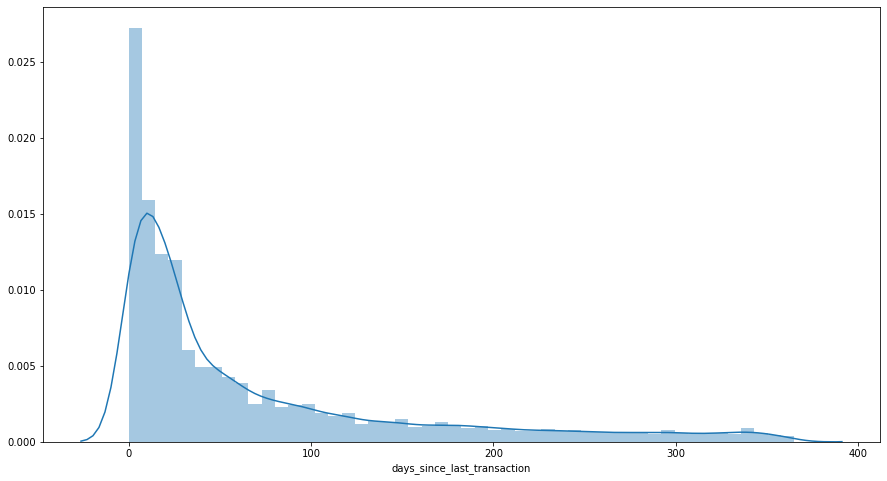

In [137]:
plt.figure(figsize=(15,8))
fig = sns.distplot(df["days_since_last_transaction"])
plt.show(fig)
## dari gambar bisa terlihat distribusi kolom "days_since_last_transaction" tidak normal
## disribusinya right skewness
## akan lebih baik apabila missing valuenya diisi dengan median, karena akan lebih mewakili keseluruhan data

In [138]:
df["days_since_last_transaction"].median()

30.0

In [139]:
filler = {
    "gender": df["gender"].mode()[0],
    "dependents": df["dependents"].mode()[0],
    "city":df["city"].mode()[0],
    "days_since_last_transaction":df["days_since_last_transaction"].median()
}
df = df.fillna(filler)

In [140]:
df.isna().sum()
## bisa dilihat masih ada missing value di kolom "occupation"
## akan di isi dengan bantuan kolom "age"

customer_id                        0
vintage                            0
age                                0
gender                             0
dependents                         0
occupation                        80
city                               0
customer_nw_category               0
branch_code                        0
days_since_last_transaction        0
current_balance                    0
previous_month_end_balance         0
average_monthly_balance_prevQ      0
average_monthly_balance_prevQ2     0
current_month_credit               0
previous_month_credit              0
current_month_debit                0
previous_month_debit               0
current_month_balance              0
previous_month_balance             0
churn                              0
dtype: int64

In [141]:
df[["occupation","age"]]
## kolom occupation akan di isi berdasarkan kategori usia,
## jadi akan dicari rata rata usia untuk setiap unique di kolom occupation
## kemudian akan di isi berdasarkan hasil rata-rata tersebut

,occupation,age
0,self_employed,66
1,self_employed,35
2,salaried,31
3,self_employed,90
4,self_employed,42
...,...,...
28377,student,10
28378,self_employed,34
28379,salaried,47
28380,self_employed,50


In [142]:
df["occupation"].unique()
## untuk menampilkan apa saja isi kolom dar "occupation" (unik)

array(['self_employed', 'salaried', 'retired', 'student', nan, 'company'],
      dtype=object)

In [143]:
df["occupation"].value_counts()
## melihat jumlah masing-masing unik di dalam kolom "occupation"
## kemudian untuk dibandingkan setelah di handling
## apakah benar akan bertambah 80 untuk masing-masing unik, karena nan ada 80 rows.

self_employed    17476
salaried          6704
student           2058
retired           2024
company             40
Name: occupation, dtype: int64

In [144]:
occ_bin =[df[df["occupation"]=="student"]["age"].mean(),
          df[df["occupation"]=="salaried"]["age"].mean(),
          df[df["occupation"]=="self_employed"]["age"].mean(),
          df[df["occupation"]=="company"]["age"].mean(),
          df[df["occupation"]=="retired"]["age"].mean()]
binn = pd.DataFrame(occ_bin,columns=["occ_mean"] ,index=['student','salaried','self_employed','company','retired'],)
binn
## akan menjadi batas
## apabila nan pada "occupation" berusia <= 19.408649 ==> student
## berusia > 19.408649 dan <= 44.058465 ==> salaried
## berusia > 44.058465 dan <= 50.302677 ==> self_employed
## berusia > 50.302677 dan <= 65.594203 ==> company
## berusia > 65.594203 ==> retired

,occ_mean
student,19.408649
salaried,44.077416
self_employed,50.303902
company,69.825000
retired,72.173419


In [145]:
occ_nan_index = df[df["occupation"].isna()].index
## occ_nan_index berisi index dimana kolom occupation bernilai nan(missing value)
for x in df["occupation"]:   ## memanfaatkan fungsi looping for loop untuk mengisi missing value pada "occupation"
    if x is np.nan:
        for i in occ_nan_index:
            if df["age"][i] <= df[df["occupation"]=="student"]["age"].mean():
                df["occupation"][i] = "student"
            elif df["age"][i] > df[df["occupation"]=="student"]["age"].mean() and df["age"][i] <= df[df["occupation"]=="salaried"]["age"].mean():
                df["occupation"][i] = "salaried"
            elif df["age"][i] > df[df["occupation"]=="salaried"]["age"].mean() and df["age"][i] <= df[df["occupation"]=="self_employed"]["age"].mean():
                df["occupation"][i] = "self_employed"
            elif df["age"][i] >= df[df["occupation"]=="self_employed"]["age"].mean() and df["age"][i] < df[df["occupation"]=="company"]["age"].mean() :
                df["occupation"][i] = "company"
            elif df["age"][i] > df[df["occupation"]=="company"]["age"].mean():
                df["occupation"][i] = "retired"

In [146]:
df.isna().sum()
## semua kolom sudah tidak ada missing value

customer_id                       0
vintage                           0
age                               0
gender                            0
dependents                        0
occupation                        0
city                              0
customer_nw_category              0
branch_code                       0
days_since_last_transaction       0
current_balance                   0
previous_month_end_balance        0
average_monthly_balance_prevQ     0
average_monthly_balance_prevQ2    0
current_month_credit              0
previous_month_credit             0
current_month_debit               0
previous_month_debit              0
current_month_balance             0
previous_month_balance            0
churn                             0
dtype: int64

In [147]:
df["occupation"].value_counts()
## dapat dilihat
## kolom self_employed meningkat sebanyak 8
## salaried meningkat sebanyak 18
## student tidak mengalami perubahan(nan tidak ada yang <= 19.408649 )
## retired meningkat 25
## company meningkat 29
## 8 + 18 + 25 + 29 = 80(jumlah missing value pada "occupation")
## jadi missing value terisi dengan benar.

self_employed    17484
salaried          6722
student           2058
retired           2049
company             69
Name: occupation, dtype: int64

# OUTLIERS

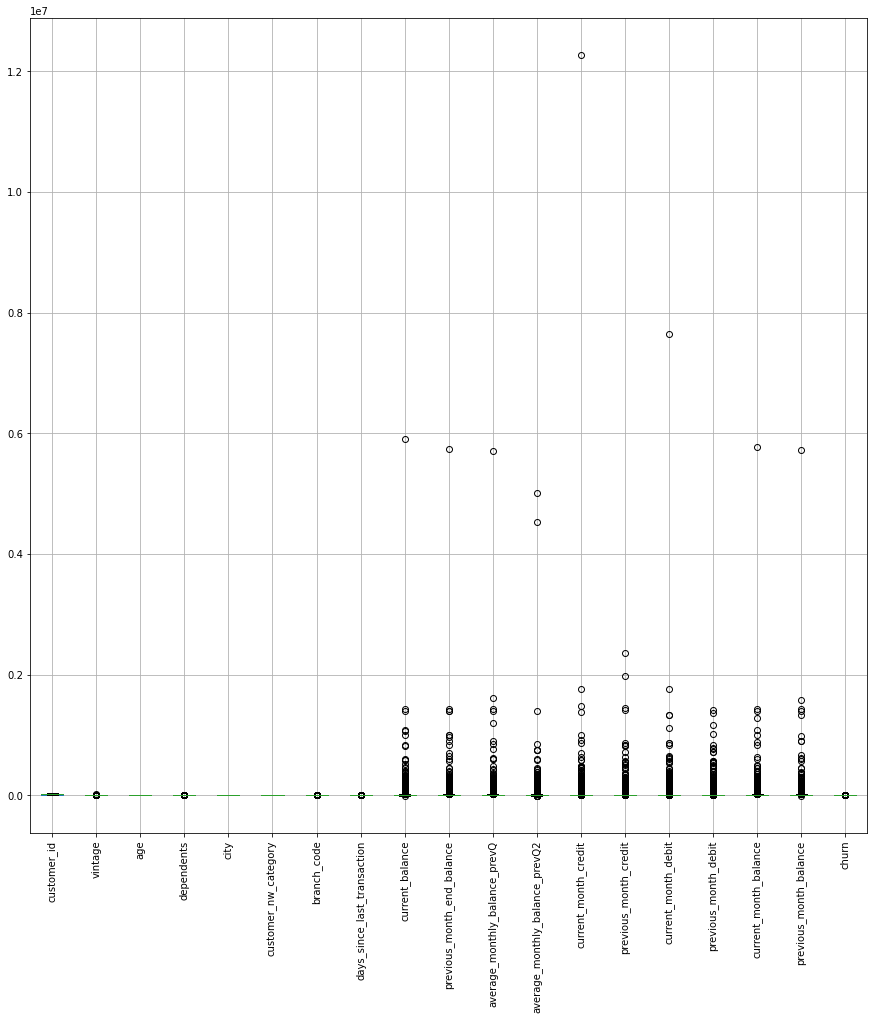

In [149]:
plt.figure(figsize=(15,15))
fig = df.boxplot()
fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
plt.show(fig)
## yang akan di handle outliernya adalah vintage,branch_code,days_since_last_transaction
## sisanya akan dibiarkan, karena merupakan nominal harga, jadi sangat mungkin/cenderung normal ada outliers
## untuk dependents, juga akan dibiarkan, karena jumlah tanggunangan orang sangat mungkin, terjadi perbedaan signifikan
## vintage merupakan jumlah hari lama nasabah sudah bergabung, jadi sangat mungkin untuk ada outliers
## branch_code merupakan code kota, jadi sangat mungkin untuk ada outliers
## days_since_last_transaction merupakan kapan hari terakhir melakukan transaksi
## karena untuk setiap nasabah bisa sangat bervariasi, jadi sangat munkgin ada outliers

# BINNING

In [150]:
## AGE BINNING
age_bin = [0,10,19,60,df["age"].max()]
label = ["Anak-anak","Remaja","Dewasa","Lansia"]
df["Age_bin"] = pd.cut(df["age"],bins=age_bin,labels=label)
## akan dibagi menjadi :
## untuk usia > 0 dan <= 10 ==> Anak-anak
## untuk usia > 10 dan <= 19 ==> Remaja
## unutk usia > 19 dan <= 60 ==> Dewasa
## untuk usia > 60 ==> Lansia

In [151]:
def con_binning(x) :
    '''
    con_binning = mau melakukan pembagian kategori pada kolom continuous(yang ada pada variabel nama),
    dengan cara, melihat dari tabel deskriptifnya.
    nama = kolom yang isinya mau di ubah sesuai fungsi function con_binning
    x = setiap isi dari kolom(kolom di dalam variabel nama) yang mau di apply function ini
    '''
    nama = ['current_balance', 'previous_month_end_balance', 'average_monthly_balance_prevQ',
           'average_monthly_balance_prevQ2', 'current_month_credit','previous_month_credit', 
           'current_month_debit', 'previous_month_debit','current_month_balance', 'previous_month_balance']
    for i in nama : 
        if x <= df[i].describe().T["25%"] :
                return "rendah"
        elif x > df[i].describe().T["25%"] and x <= df[i].describe().T["50%"] :
            return "cukup_rendah"
        elif x > df[i].describe().T["50%"] and x <= df[i].describe().T["75%"] :
            return "cukup_tinggi"
        elif x > df[i].describe().T["75%"] :
            return "tinggi"

def recat_dependents(x):
    '''
    recat_dependents = membuat kategori baru pada kolom dependents, menjadi biner (0/1),
    yaitu 1 untuk ada tanggunan dan 0 untuk tidak ada tanggunan.
    x = setiap isi dalam kolom(dalam kasus ini kolom "dependents"), yang akan di apply function ini.
    '''
    if x == 0.0 :
        return 0
    elif x != 0.0 :
        return 1

In [152]:
df["dependents"] = df["dependents"].apply(recat_dependents)

In [153]:
nama = ['current_balance', 'previous_month_end_balance', 'average_monthly_balance_prevQ',
           'average_monthly_balance_prevQ2', 'current_month_credit','previous_month_credit', 
           'current_month_debit', 'previous_month_debit','current_month_balance', 'previous_month_balance']
for i in nama :
    df[i+"_bin"] = df[i].apply(con_binning)
    print (f"BINNING {i} DONE !!")
print ("======================")
print ("===== ALL DONE!! =====")
print ("======================")
## dilakukan untuk memudahkan proses EDA
## karena apabila tidak dibinning, tidak begitu kelihatan efeknya
## setelah dibinning akan terlihat pada saat EDA baik plot maupub crosstab

## CARA LAIN 
# df["current_balance_bin"] = df['current_balance'].apply(con_binning)
# df["previous_month_end_balance_bin"] = df['previous_month_end_balance'].apply(con_binning)
# df["average_monthly_balance_prevQ_bin"] = df['average_monthly_balance_prevQ'].apply(con_binning)
# df["average_monthly_balance_prevQ2_bin"] = df['average_monthly_balance_prevQ2'].apply(con_binning)
# df["current_month_credit_bin"] = df['current_month_credit'].apply(con_binning)
# df["previous_month_credit_bin"] = df['previous_month_credit'].apply(con_binning)
# df["current_month_debit_bin"] = df['current_month_debit'].apply(con_binning)
# df["previous_month_debit_bin"] = df['previous_month_debit'].apply(con_binning)
# df["current_month_balance_bin"] = df['current_month_balance'].apply(con_binning)
# df["previous_month_balance_bin"] = df['previous_month_balance'].apply(con_binning)

BINNING current_balance DONE !!
BINNING previous_month_end_balance DONE !!
BINNING average_monthly_balance_prevQ DONE !!
BINNING average_monthly_balance_prevQ2 DONE !!
BINNING current_month_credit DONE !!
BINNING previous_month_credit DONE !!
BINNING current_month_debit DONE !!
BINNING previous_month_debit DONE !!
BINNING current_month_balance DONE !!
BINNING previous_month_balance DONE !!
===== ALL DONE!! =====


In [154]:
df.isna().sum()

customer_id                           0
vintage                               0
age                                   0
gender                                0
dependents                            0
occupation                            0
city                                  0
customer_nw_category                  0
branch_code                           0
days_since_last_transaction           0
current_balance                       0
previous_month_end_balance            0
average_monthly_balance_prevQ         0
average_monthly_balance_prevQ2        0
current_month_credit                  0
previous_month_credit                 0
current_month_debit                   0
previous_month_debit                  0
current_month_balance                 0
previous_month_balance                0
churn                                 0
Age_bin                               0
current_balance_bin                   0
previous_month_end_balance_bin        0
average_monthly_balance_prevQ_bin     0


# EDA

In [156]:
df.columns

Index(['customer_id', 'vintage', 'age', 'gender', 'dependents', 'occupation',
       'city', 'customer_nw_category', 'branch_code',
       'days_since_last_transaction', 'current_balance',
       'previous_month_end_balance', 'average_monthly_balance_prevQ',
       'average_monthly_balance_prevQ2', 'current_month_credit',
       'previous_month_credit', 'current_month_debit', 'previous_month_debit',
       'current_month_balance', 'previous_month_balance', 'churn', 'Age_bin',
       'current_balance_bin', 'previous_month_end_balance_bin',
       'average_monthly_balance_prevQ_bin',
       'average_monthly_balance_prevQ2_bin', 'current_month_credit_bin',
       'previous_month_credit_bin', 'current_month_debit_bin',
       'previous_month_debit_bin', 'current_month_balance_bin',
       'previous_month_balance_bin'],
      dtype='object')

## CHURN

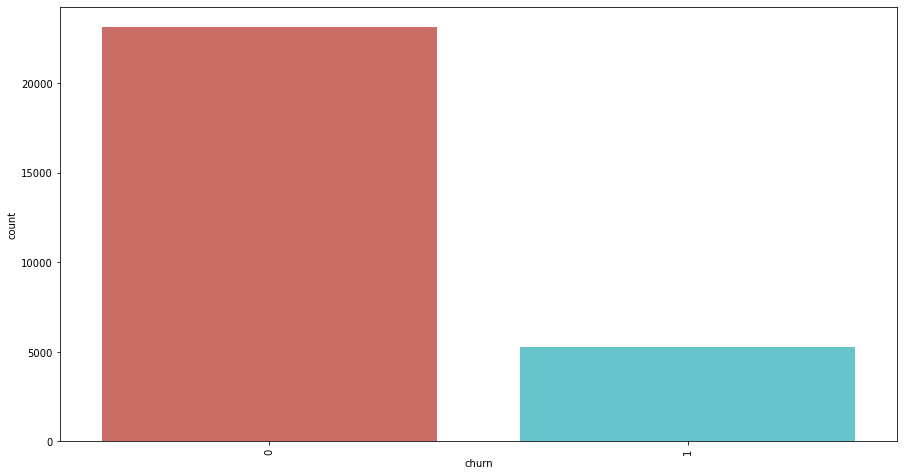

In [157]:
plt.figure(figsize=(15,8))
fig = sns.countplot(x=df["churn"],palette="hls")
fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
plt.show(fig)

In [158]:
pd.crosstab(index = df["churn"],columns = "Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

col_0,Jumlah
churn,
0,23122
1,5260


In [159]:
pd.crosstab(index = df["churn"],columns = "%churn",normalize=True).sort_values(by="%churn",ascending=False).head(10)
## Terlihat kolom churn imbalance, akan di handle nanti sebelum dilakukan proses Machine Learning

col_0,%churn
churn,
0,0.814671
1,0.185329


## VINTAGE

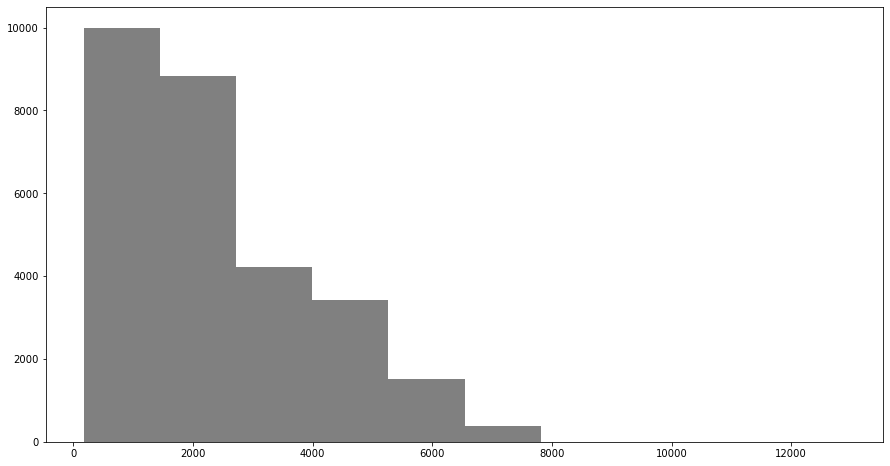

In [160]:
plt.figure(figsize=(15,8))
fig = plt.hist(df["vintage"],color="grey")
plt.show(fig)

In [161]:
pd.crosstab(index = df["vintage"],columns = "Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

col_0,Jumlah
vintage,
1432,25
1997,23
403,21
1718,20
1400,20
439,19
287,19
626,19
1169,19


In [162]:
pd.crosstab(index = [df[df["churn"]==1]["vintage"],df["churn"]],columns = "%churn_1",normalize=True).sort_values(by="%churn_1",ascending=False).head(10)
## dari kolom "vintage" tidak begitu kelihatan customer akan berpindah tempat(bank) atau tidak
## perbedaan antara top 10 churn tertingginya, presentase nya sangat tidak signifikan perubahannya

,col_0,%churn_1
vintage,churn,
220,1,0.001521
1503,1,0.001521
1411,1,0.001331
318,1,0.001331
2285,1,0.001331
311,1,0.001331
224,1,0.001331
1466,1,0.001331
626,1,0.001141


## AGE

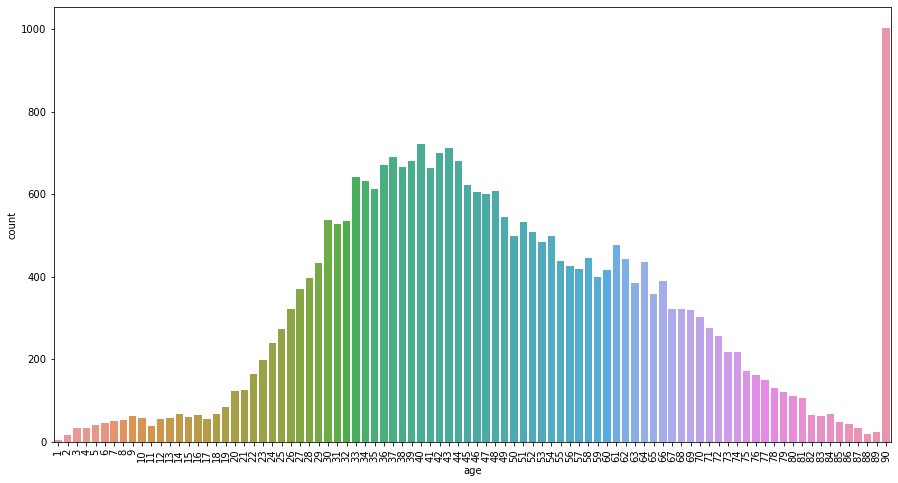

In [163]:
plt.figure(figsize=(15,8))
fig = sns.countplot(x= df["age"])
fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
plt.show(fig)

In [164]:
pd.crosstab(index = df["age"],columns = "Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

col_0,Jumlah
age,
90,1003
40,722
43,711
42,699
37,691
44,680
39,680
36,670
38,666


In [165]:
pd.crosstab(index = [df[df["churn"]==1]["age"],df["churn"]],columns = "%churn_1",normalize=True).sort_values(by="%churn_1",ascending=False).head(10)
## presentase nya terihat tidak memiliki beda yang signifikan
## sehingga mungkin usia tidak terlalu mempengaruhi (karena belum di binning)

,col_0,%churn_1
age,churn,
90,1,0.033460
43,1,0.027376
40,1,0.027186
37,1,0.026426
48,1,0.026236
36,1,0.025475
34,1,0.024905
44,1,0.024715
38,1,0.023954


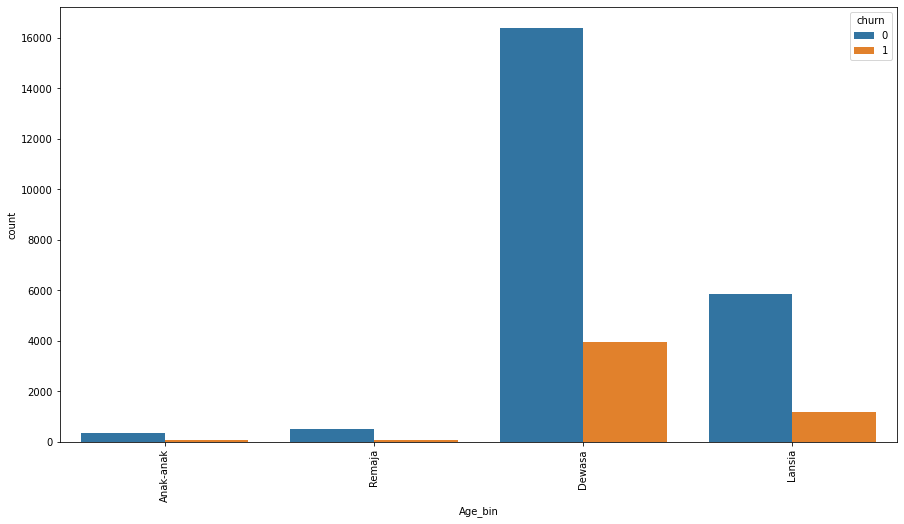

In [166]:
plt.figure(figsize=(15,8))
fig = sns.countplot(x= df["Age_bin"],hue=df["churn"])
fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
plt.show(fig)

In [167]:
pd.crosstab(index = [df[df["churn"]==1]["Age_bin"],df["churn"]],columns = "Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

,col_0,Jumlah
Age_bin,churn,
Dewasa,1,3961
Lansia,1,1179
Remaja,1,68
Anak-anak,1,52


In [168]:
pd.crosstab(index = [df[df["churn"]==1]["Age_bin"],df["churn"]],columns = "%churn_1",normalize=True).sort_values(by="%churn_1",ascending=False).head(10)
## tapi apabila dilakukan binning, dapat terlihat
## pada kategori usia dewasa (20-60 tahun), terlihat perbedaan yang sangat signifikan

,col_0,%churn_1
Age_bin,churn,
Dewasa,1,0.753042
Lansia,1,0.224144
Remaja,1,0.012928
Anak-anak,1,0.009886


## GENDER

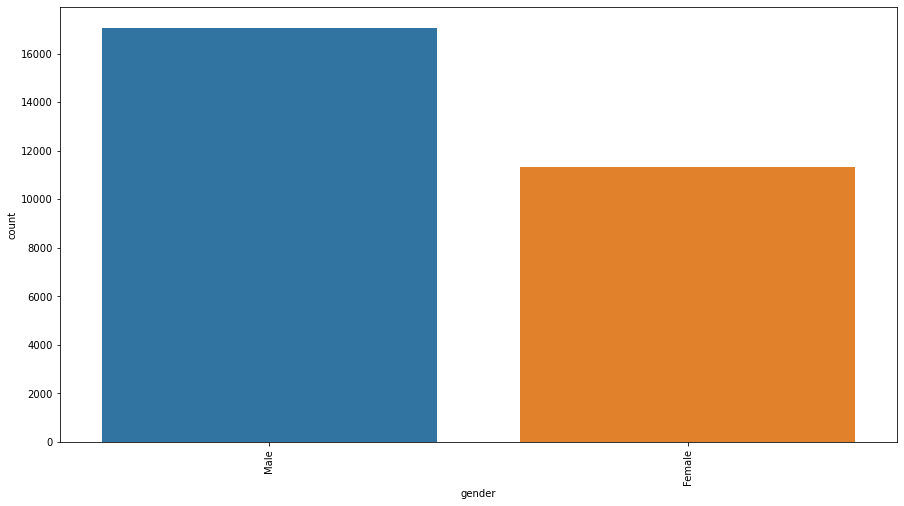

In [169]:
plt.figure(figsize=(15,8))
fig = sns.countplot(x= df["gender"])
fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
plt.show(fig)

In [170]:
pd.crosstab(index = df["gender"],columns = "Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

col_0,Jumlah
gender,
Male,17073
Female,11309


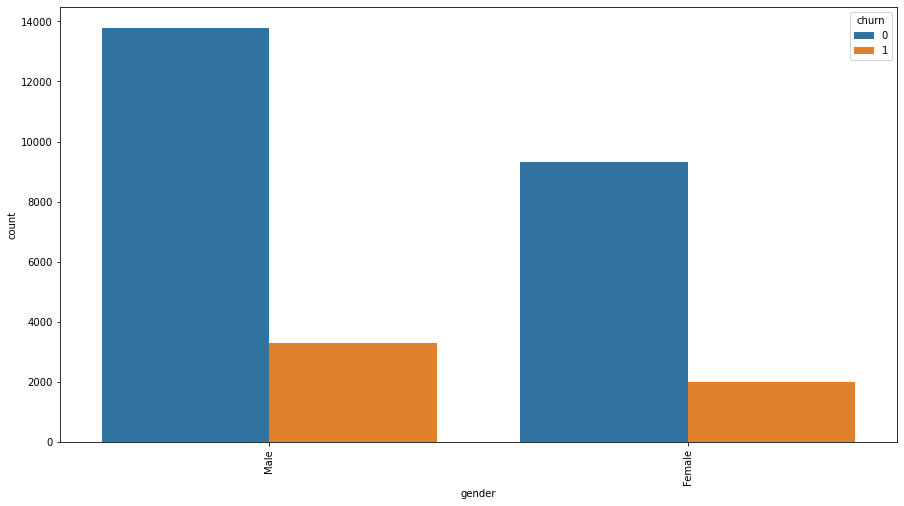

In [171]:
plt.figure(figsize=(15,8))
fig = sns.countplot(x= df["gender"],hue=df["churn"])
fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
plt.show(fig)

In [172]:
pd.crosstab(index = [df[df["churn"]==1]["gender"],df["churn"]],columns = "Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

,col_0,Jumlah
gender,churn,
Male,1,3275
Female,1,1985


In [173]:
pd.crosstab(index = [df[df["churn"]==1]["gender"],df["churn"]],columns = "%churn_1",normalize=True).sort_values(by="%churn_1",ascending=False).head(10)
## Dapat terlihat gender juga memiliki pengaruh yang pending pada kolom churn
## gender Male memiliki kecenderungan lebih tinggi untuk berpindah bank

,col_0,%churn_1
gender,churn,
Male,1,0.622624
Female,1,0.377376


## DEPENDENTS

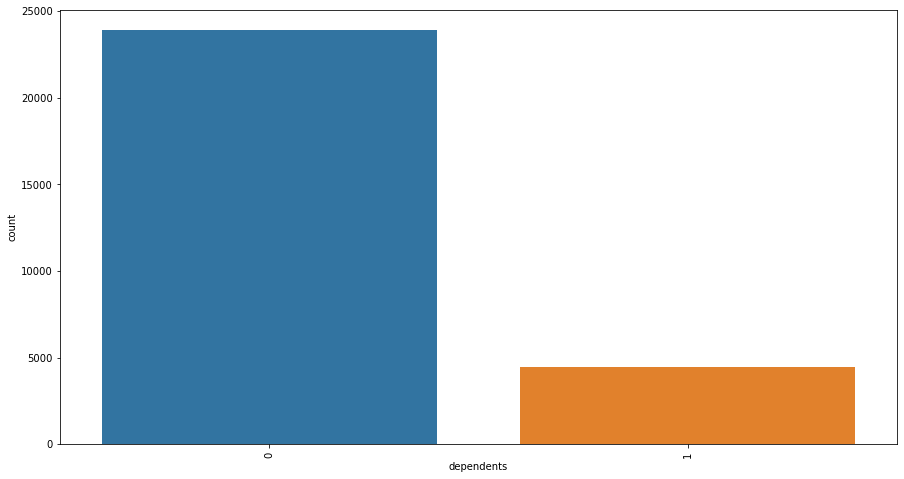

In [174]:
plt.figure(figsize=(15,8))
fig = sns.countplot(x= df["dependents"])
fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
plt.show(fig)

In [175]:
pd.crosstab(index = df["dependents"],columns = "Jumlah").sort_values(by="Jumlah",ascending=False)

col_0,Jumlah
dependents,
0,23898
1,4484


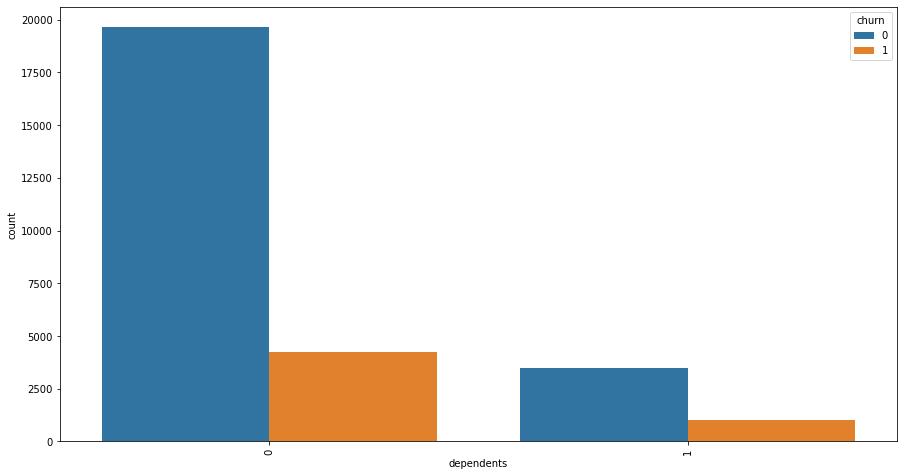

In [176]:
plt.figure(figsize=(15,8))
fig = sns.countplot(x= df["dependents"],hue=df["churn"])
fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
plt.show(fig)

In [177]:
pd.crosstab(index = [df[df["churn"]==1]["dependents"],df["churn"]],columns = "%churn_1",normalize=True).sort_values(by="%churn_1",ascending=False).head(10)
## nasabah yang tidak memiliki tanggungan memiliki kecenderungan lebih tinggi untuk berpindah bank

,col_0,%churn_1
dependents,churn,
0,1,0.810266
1,1,0.189734


## OCCUPATION

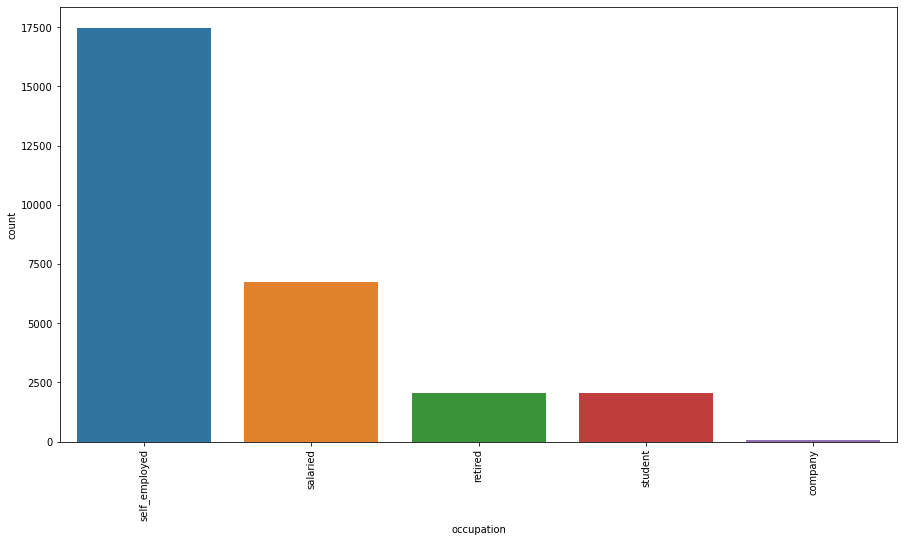

In [178]:
plt.figure(figsize=(15,8))
fig = sns.countplot(x= df["occupation"])
fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
plt.show(fig)

In [179]:
pd.crosstab(index = df["occupation"],columns = "Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

col_0,Jumlah
occupation,
self_employed,17484
salaried,6722
student,2058
retired,2049
company,69


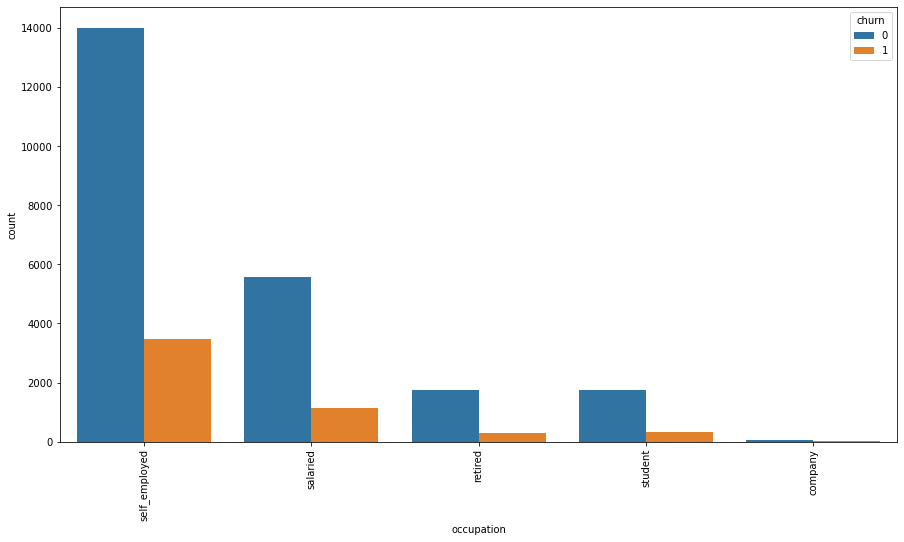

In [180]:
plt.figure(figsize=(15,8))
fig = sns.countplot(x= df["occupation"],hue=df["churn"])
fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
plt.show(fig)

In [181]:
pd.crosstab(index = [df[df["churn"]==1]["occupation"],df["churn"]],columns = "%churn_1",normalize=True).sort_values(by="%churn_1",ascending=False).head(10)
## terlihat pengaruhnya juga tinggi
## nasabah yang occupationnya merupakan mempekerjakan diri sendiri(memiliki bisnis sendiri)
## memiliki kecenderungan lebih tinggi, untuk berpindah bank.

,col_0,%churn_1
occupation,churn,
self_employed,1,0.659696
salaried,1,0.218631
student,1,0.061597
retired,1,0.058555
company,1,0.001521


## CITY

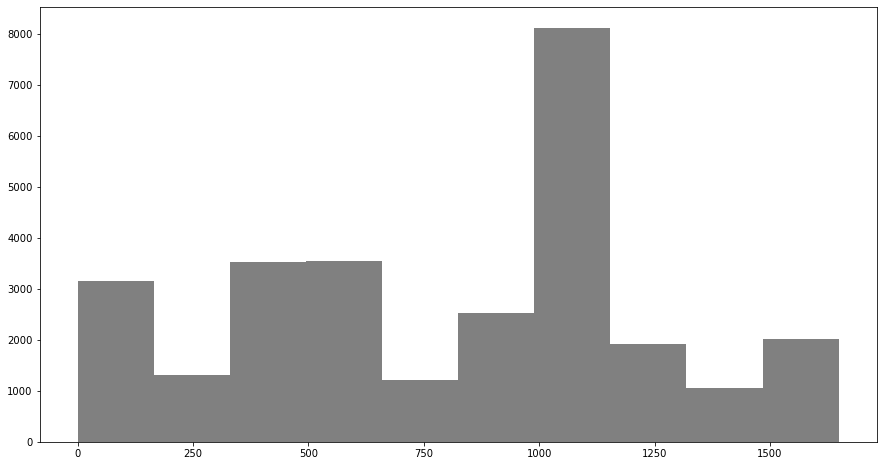

In [182]:
plt.figure(figsize=(15,8))
fig = plt.hist(df["city"],color="grey")
plt.show(fig)

In [183]:
pd.crosstab(index = df["city"],columns = "Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

col_0,Jumlah
city,
1020.0,4282
1096.0,2016
409.0,1334
146.0,1291
834.0,1138
334.0,930
1232.0,840
623.0,778
15.0,669


In [184]:
pd.crosstab(index = [df[df["churn"]==1]["city"],df["churn"]],columns = "%churn_1",normalize=True).sort_values(by="%churn_1",ascending=False).head(10)
## nasabah di kota dengan code kota 1020, memiliki kecenderungan lebih tinggi untuk berpindah bank

,col_0,%churn_1
city,churn,
1020.0,1,0.146958
1096.0,1,0.062167
409.0,1,0.042586
146.0,1,0.042586
834.0,1,0.039544
334.0,1,0.033460
623.0,1,0.030798
1232.0,1,0.029658
15.0,1,0.023764


## CUSTOMER_NW_CATEGORY

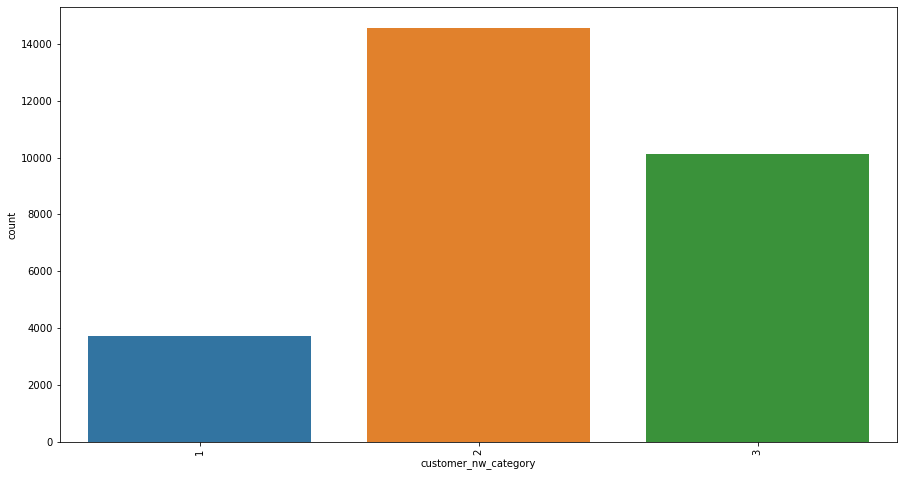

In [185]:
plt.figure(figsize=(15,8))
fig = sns.countplot(x= df["customer_nw_category"])
fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
plt.show(fig)

In [186]:
pd.crosstab(index = df["customer_nw_category"],columns = "Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

col_0,Jumlah
customer_nw_category,
2,14559
3,10112
1,3711


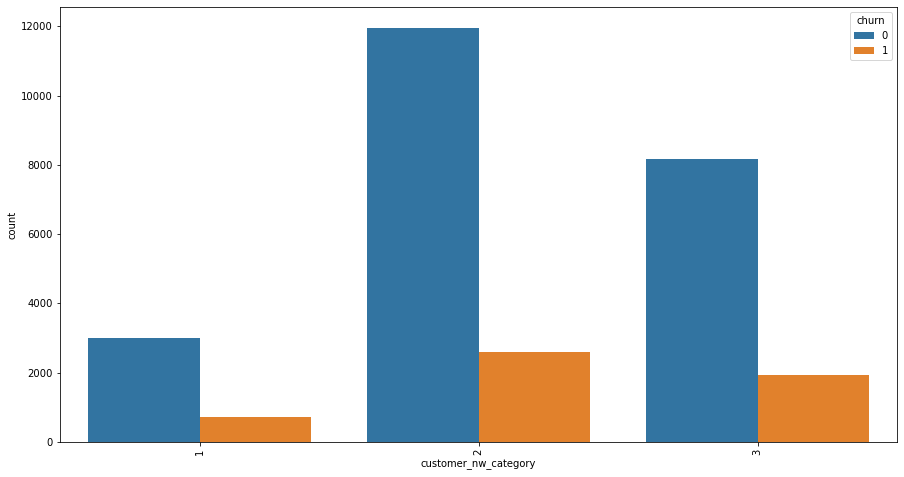

In [187]:
plt.figure(figsize=(15,8))
fig = sns.countplot(x= df["customer_nw_category"],hue=df["churn"])
fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
plt.show(fig)

In [188]:
pd.crosstab(index = [df[df["churn"]==1]["customer_nw_category"],df["churn"]],columns = "Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

,col_0,Jumlah
customer_nw_category,churn,
2,1,2606
3,1,1944
1,1,710


In [189]:
pd.crosstab(index = [df[df["churn"]==1]["customer_nw_category"],df["churn"]],columns = "%churn_1",normalize=True).sort_values(by="%churn_1",ascending=False).head(10)
## customer dengan net worth kelas 2 cenderung memiliki kemungkinan lebih besar untuk berpindah bank

,col_0,%churn_1
customer_nw_category,churn,
2,1,0.495437
3,1,0.369582
1,1,0.134981


## BRANCH_CODE

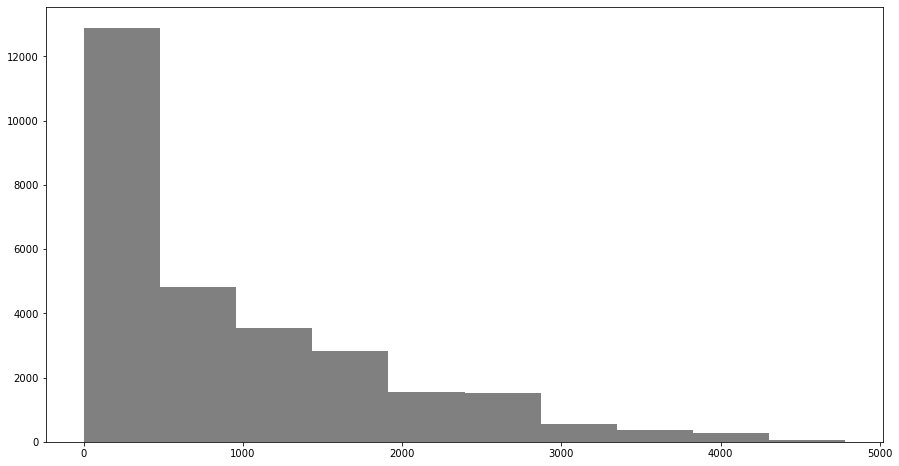

In [190]:
plt.figure(figsize=(15,8))
fig = plt.hist(df["branch_code"],color="grey")
plt.show(fig)

In [191]:
pd.crosstab(index = df["branch_code"],columns = "Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

col_0,Jumlah
branch_code,
19,145
6,142
60,128
16,111
8,109
92,105
27,96
79,93
88,93


In [192]:
pd.crosstab(index = [df[df["churn"]==1]["branch_code"],df["churn"]],columns = "%churn_1",normalize=True).sort_values(by="%churn_1",ascending=False).head(10)
## kantor cabang dari bank kita tidak berpengaruh
## karena dapat dilihat dari presentasenya bahwa pengaruhnya tidak signifikan

,col_0,%churn_1
branch_code,churn,
6,1,0.006654
79,1,0.004943
47,1,0.004563
60,1,0.004563
19,1,0.004183
92,1,0.003802
7,1,0.003802
501,1,0.003802
16,1,0.003422


## DAYS_SINCE_LAST_TRANSACTION

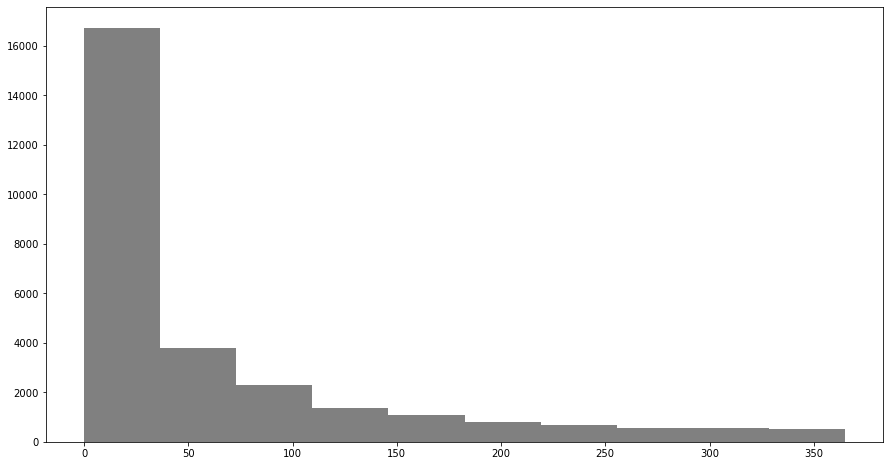

In [193]:
plt.figure(figsize=(15,8))
fig = plt.hist(df["days_since_last_transaction"],color="grey")
plt.show(fig)

In [194]:
pd.crosstab(index = df["days_since_last_transaction"],columns = "Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

col_0,Jumlah
days_since_last_transaction,
30.0,3414
0.0,1672
3.0,831
14.0,654
4.0,632
6.0,596
5.0,576
7.0,561
11.0,486


In [195]:
pd.crosstab(index = [df[df["churn"]==1]["days_since_last_transaction"],df["churn"]],columns = "%churn_1",normalize=True).sort_values(by="%churn_1",ascending=False).head(10)
## hari terakhir transaksi tidak terlalu berpengaruh
## dapat dilihat bahwa presentase kemungkinan nasabah untuk pindah banknya tidak memiliki perbedaan yang signifikan

,col_0,%churn_1
days_since_last_transaction,churn,
30.0,1,0.065019
0.0,1,0.054373
3.0,1,0.035171
7.0,1,0.025665
14.0,1,0.024905
4.0,1,0.024525
5.0,1,0.022243
21.0,1,0.021103
13.0,1,0.020532


## CURRENT BALANCE

In [196]:
pd.crosstab(index = df["current_balance"],columns = "Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

col_0,Jumlah
current_balance,
1429.07,6
1428.73,5
1428.94,4
1429.20,4
1429.14,4
1428.79,4
1428.76,4
1428.93,4
1429.19,3


In [197]:
pd.crosstab(index = [df[df["churn"]==1]["current_balance"],df["churn"]],columns = "%churn_1",normalize=True).sort_values(by="%churn_1",ascending=False).head(10)
## kolom continuos memang tidak akan terlihat pengaruhnya

,col_0,%churn_1
current_balance,churn,
0.06,1,0.00057
217.01,1,0.00038
1428.70,1,0.00038
0.63,1,0.00038
1433.48,1,0.00038
1101.30,1,0.00038
66.81,1,0.00038
0.98,1,0.00038
1.03,1,0.00038


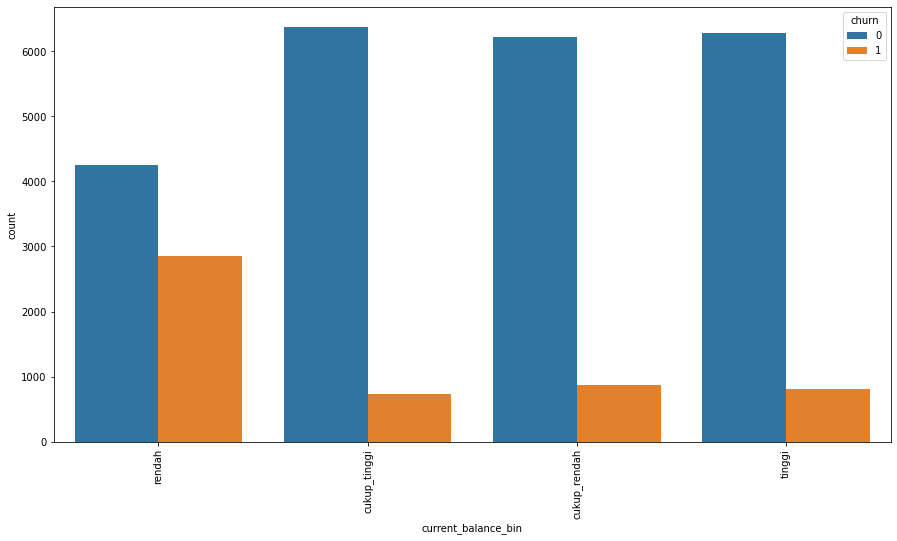

In [198]:
plt.figure(figsize=(15,8))
fig = sns.countplot(x= df["current_balance_bin"],hue=df["churn"])
fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
plt.show(fig)

In [199]:
pd.crosstab(index = [df[df["churn"]==1]["current_balance_bin"],df["churn"]],columns = "Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

,col_0,Jumlah
current_balance_bin,churn,
rendah,1,2846
cukup_rendah,1,877
tinggi,1,808
cukup_tinggi,1,729


In [200]:
pd.crosstab(index = [df[df["churn"]==1]["current_balance_bin"],df["churn"]],columns = "%churn_1",normalize=True).sort_values(by="%churn_1",ascending=False).head(10)
## current balance dengan category rendah (-5503.96 - 1784.47) memiliki kecenderungan untuk berpindah bank
## paling tinggi dibanding yang lain

,col_0,%churn_1
current_balance_bin,churn,
rendah,1,0.541065
cukup_rendah,1,0.166730
tinggi,1,0.153612
cukup_tinggi,1,0.138593


## PREVIOUS_MONTH_END_BALANCE

In [201]:
pd.crosstab(index = df["previous_month_end_balance"],columns = "Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

col_0,Jumlah
previous_month_end_balance,
1428.73,5
1428.83,5
1429.14,4
1425.41,3
0.50,3
2188.61,3
1428.94,3
1454.75,3
2069.37,3


In [202]:
pd.crosstab(index = [df[df["churn"]==1]["previous_month_end_balance"],df["churn"]],columns = "%churn_1",normalize=True).sort_values(by="%churn_1",ascending=False).head(10)

,col_0,%churn_1
previous_month_end_balance,churn,
352.00,1,0.00038
2816.79,1,0.00038
3490.02,1,0.00038
11.60,1,0.00038
237.16,1,0.00038
1425.41,1,0.00038
1428.83,1,0.00038
7295.69,1,0.00038
1429.10,1,0.00038


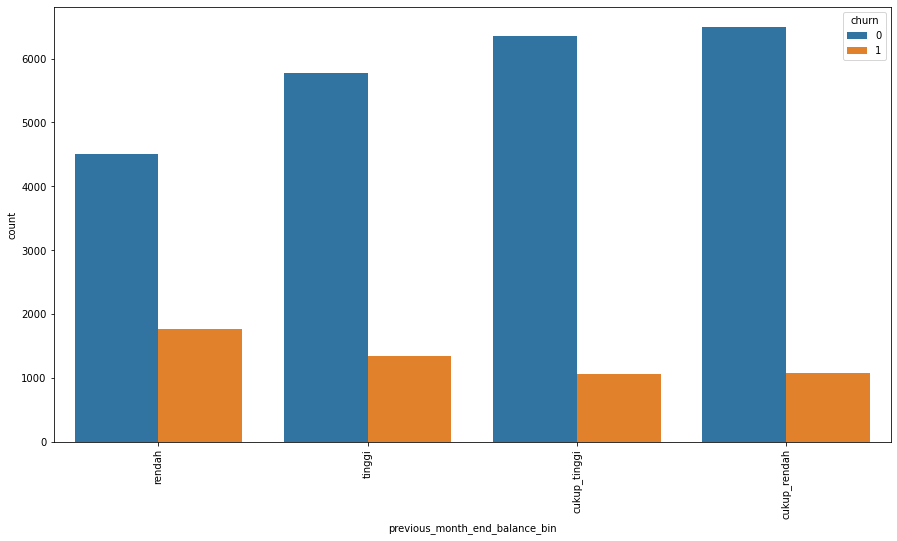

In [203]:
plt.figure(figsize=(15,8))
fig = sns.countplot(x= df["previous_month_end_balance_bin"],hue=df["churn"])
fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
plt.show(fig)

In [204]:
pd.crosstab(index = [df[df["churn"]==1]["previous_month_end_balance_bin"],df["churn"]],columns = "Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

,col_0,Jumlah
previous_month_end_balance_bin,churn,
rendah,1,1770
tinggi,1,1347
cukup_rendah,1,1077
cukup_tinggi,1,1066


In [205]:
pd.crosstab(index = [df[df["churn"]==1]["previous_month_end_balance_bin"],df["churn"]],columns = "%churn_1",normalize=True).sort_values(by="%churn_1",ascending=False).head(10)
## pengaruh dari previous month end balance juga terlihat setelah dibinning
## category rendah menjadi category yang memiliki kemungkinan nasabah untuk berpindah bank paling tinggi.

,col_0,%churn_1
previous_month_end_balance_bin,churn,
rendah,1,0.336502
tinggi,1,0.256084
cukup_rendah,1,0.204753
cukup_tinggi,1,0.202662


## AVERAGE_MONTHLY_BALANCE_PREVQ

In [206]:
pd.crosstab(index = df["average_monthly_balance_prevQ"],columns = "Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

col_0,Jumlah
average_monthly_balance_prevQ,
1471.93,3
1451.07,3
3914.64,3
1837.71,3
1663.86,3
1541.82,3
1737.85,3
2961.71,3
2597.68,3


In [207]:
pd.crosstab(index = [df[df["churn"]==1]["average_monthly_balance_prevQ"],df["churn"]],columns = "%churn_1",normalize=True).sort_values(by="%churn_1",ascending=False).head(10)

,col_0,%churn_1
average_monthly_balance_prevQ,churn,
2110.88,1,0.00038
3062.75,1,0.00038
1455.02,1,0.00038
3002.37,1,0.00038
1753.59,1,0.00038
6123.08,1,0.00038
4593.82,1,0.00038
2161.90,1,0.00038
2968.04,1,0.00038


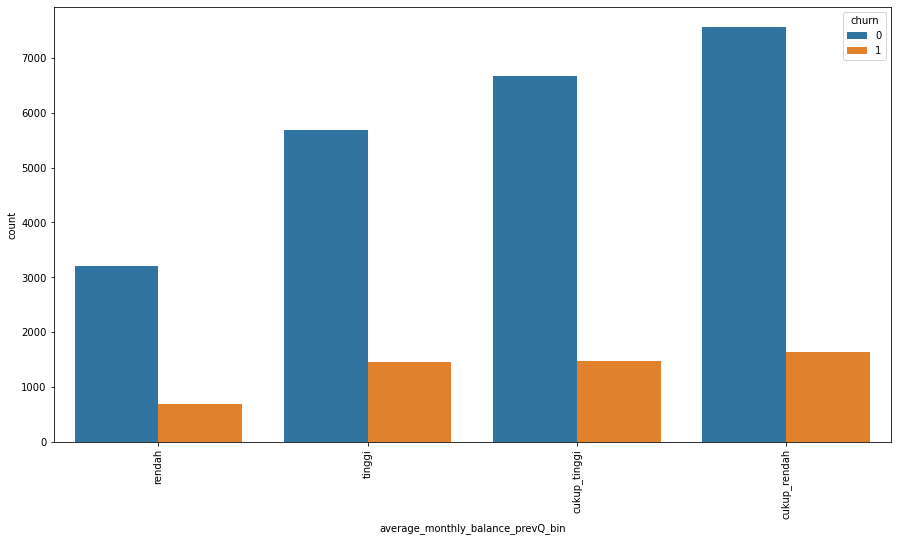

In [208]:
plt.figure(figsize=(15,8))
fig = sns.countplot(x= df["average_monthly_balance_prevQ_bin"],hue=df["churn"])
fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
plt.show(fig)

In [209]:
pd.crosstab(index = [df[df["churn"]==1]["average_monthly_balance_prevQ_bin"],df["churn"]],columns = "Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

,col_0,Jumlah
average_monthly_balance_prevQ_bin,churn,
cukup_rendah,1,1635
cukup_tinggi,1,1478
tinggi,1,1458
rendah,1,689


In [210]:
pd.crosstab(index = [df[df["churn"]==1]["average_monthly_balance_prevQ_bin"],df["churn"]],columns = "%churn_1",normalize=True).sort_values(by="%churn_1",ascending=False).head(10)
## setelah dilakukan bining baru terlihat pengaruhnya
## cukup_rendah menjadi kategori yang memiliki presentase paling tinggu untuk perpindahan customer

,col_0,%churn_1
average_monthly_balance_prevQ_bin,churn,
cukup_rendah,1,0.310837
cukup_tinggi,1,0.280989
tinggi,1,0.277186
rendah,1,0.130989


## AVERAGE_MONTHLY_BALANCE_PREVQ2

In [211]:
pd.crosstab(index = df["average_monthly_balance_prevQ2"],columns = "Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

col_0,Jumlah
average_monthly_balance_prevQ2,
0.51,3
2042.93,3
1975.82,3
569.41,3
1648.72,3
4801.09,2
1720.50,2
1721.25,2
6869.29,2


In [212]:
pd.crosstab(index = [df[df["churn"]==1]["average_monthly_balance_prevQ2"],df["churn"]],columns = "%churn_1",normalize=True).sort_values(by="%churn_1",ascending=False).head(10)

,col_0,%churn_1
average_monthly_balance_prevQ2,churn,
719.65,1,0.00038
772.11,1,0.00038
582.83,1,0.00038
790.81,1,0.00038
2487.21,1,0.00038
5558.93,1,0.00038
1441.94,1,0.00038
2580.60,1,0.00038
3195.76,1,0.00038


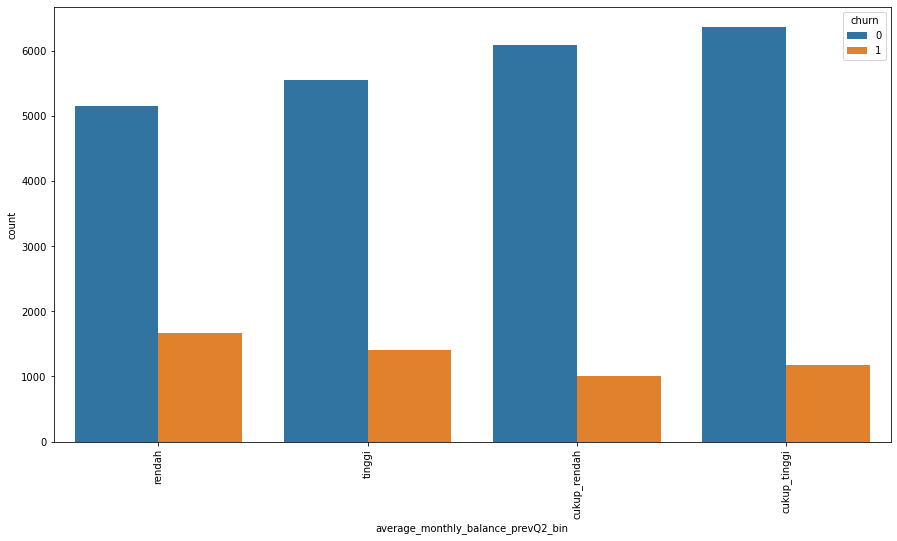

In [213]:
plt.figure(figsize=(15,8))
fig = sns.countplot(x= df["average_monthly_balance_prevQ2_bin"],hue=df["churn"])
fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
plt.show(fig)

In [214]:
pd.crosstab(index = [df[df["churn"]==1]["average_monthly_balance_prevQ2_bin"],df["churn"]],columns = "Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

,col_0,Jumlah
average_monthly_balance_prevQ2_bin,churn,
rendah,1,1664
tinggi,1,1413
cukup_tinggi,1,1176
cukup_rendah,1,1007


In [215]:
pd.crosstab(index = [df[df["churn"]==1]["average_monthly_balance_prevQ2_bin"],df["churn"]],columns = "%churn_1",normalize=True).sort_values(by="%churn_1",ascending=False).head(10)
## setelah dilakukan bining baru terlihat pengaruhnya
## rendah menjadi kategori yang memiliki presentase paling tinggu untuk perpindahan customer

,col_0,%churn_1
average_monthly_balance_prevQ2_bin,churn,
rendah,1,0.316350
tinggi,1,0.268631
cukup_tinggi,1,0.223574
cukup_rendah,1,0.191445


## CURRENT_MONTH_CREDIT

In [216]:
pd.crosstab(index = df["current_month_credit"],columns = "Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

col_0,Jumlah
current_month_credit,
0.49,366
0.47,363
0.16,361
0.59,361
0.03,355
0.10,352
0.43,347
0.60,347
0.14,346


In [217]:
pd.crosstab(index = [df[df["churn"]==1]["current_month_credit"],df["churn"]],columns = "%churn_1",normalize=True).sort_values(by="%churn_1",ascending=False).head(10)

,col_0,%churn_1
current_month_credit,churn,
0.47,1,0.014639
0.07,1,0.013688
0.49,1,0.013498
0.37,1,0.013308
0.17,1,0.013118
0.06,1,0.012928
0.16,1,0.012738
0.63,1,0.012357
0.53,1,0.012357


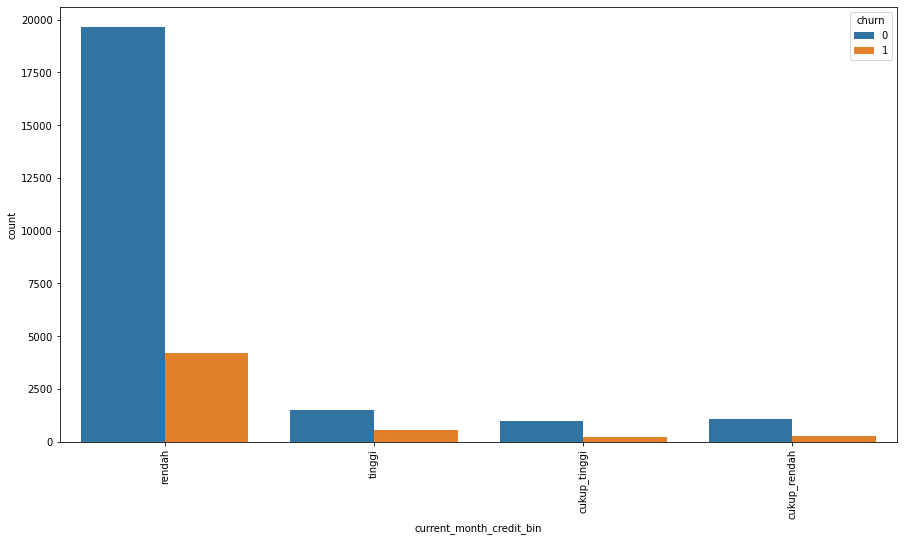

In [218]:
plt.figure(figsize=(15,8))
fig = sns.countplot(x= df["current_month_credit_bin"],hue=df["churn"])
fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
plt.show(fig)

In [219]:
pd.crosstab(index = [df[df["churn"]==1]["current_month_credit_bin"],df["churn"]],columns = "Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

,col_0,Jumlah
current_month_credit_bin,churn,
rendah,1,4212
tinggi,1,550
cukup_rendah,1,275
cukup_tinggi,1,223


In [220]:
pd.crosstab(index = [df[df["churn"]==1]["current_month_credit_bin"],df["churn"]],columns = "%churn_1",normalize=True).sort_values(by="%churn_1",ascending=False).head(10)
## setelah dilakukan bining baru terlihat pengaruhnya
## rendah menjadi kategori yang memiliki presentase paling tinggu untuk perpindahan customer

,col_0,%churn_1
current_month_credit_bin,churn,
rendah,1,0.800760
tinggi,1,0.104563
cukup_rendah,1,0.052281
cukup_tinggi,1,0.042395


## PREVIOUS_MONTH_CREDIT

In [221]:
pd.crosstab(index = df["previous_month_credit"],columns = "Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

col_0,Jumlah
previous_month_credit,
0.59,366
0.19,353
0.01,349
0.24,345
0.60,342
0.56,341
0.46,338
0.49,338
0.03,337


In [222]:
pd.crosstab(index = [df[df["churn"]==1]["previous_month_credit"],df["churn"]],columns = "%churn_1",normalize=True).sort_values(by="%churn_1",ascending=False).head(10)

,col_0,%churn_1
previous_month_credit,churn,
0.01,1,0.013118
0.37,1,0.012928
0.47,1,0.012928
0.06,1,0.012167
0.17,1,0.011977
0.07,1,0.011787
0.27,1,0.011597
0.09,1,0.011407
0.64,1,0.011407


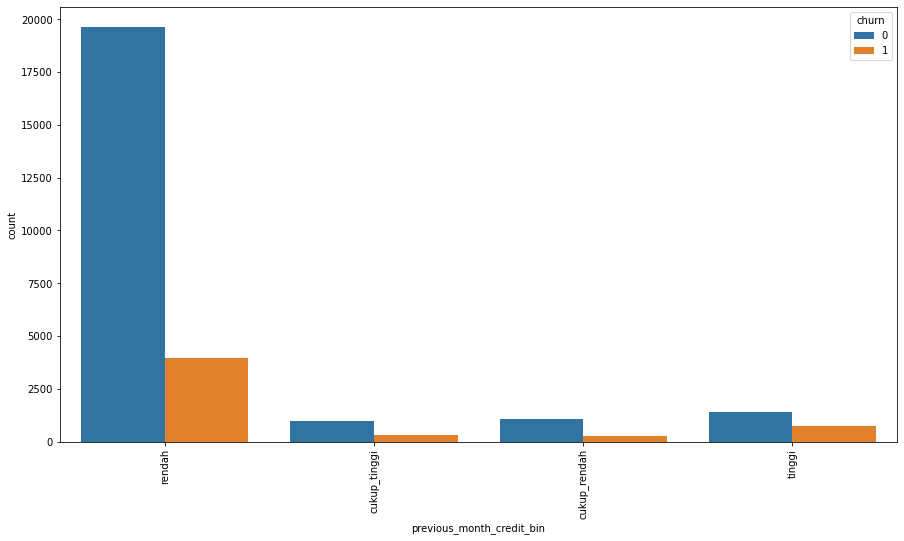

In [223]:
plt.figure(figsize=(15,8))
fig = sns.countplot(x= df["previous_month_credit_bin"],hue=df["churn"])
fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
plt.show(fig)

In [224]:
pd.crosstab(index = [df[df["churn"]==1]["previous_month_credit_bin"],df["churn"]],columns = "Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

,col_0,Jumlah
previous_month_credit_bin,churn,
rendah,1,3964
tinggi,1,719
cukup_tinggi,1,316
cukup_rendah,1,261


In [225]:
pd.crosstab(index = [df[df["churn"]==1]["previous_month_credit_bin"],df["churn"]],columns = "%churn_1",normalize=True).sort_values(by="%churn_1",ascending=False).head(10)
## setelah dilakukan bining baru terlihat pengaruhnya
## rendah menjadi kategori yang memiliki presentase paling tinggu untuk perpindahan customer

,col_0,%churn_1
previous_month_credit_bin,churn,
rendah,1,0.753612
tinggi,1,0.136692
cukup_tinggi,1,0.060076
cukup_rendah,1,0.049620


## CURRENT_MONTH_DEBIT

In [226]:
pd.crosstab(index = df["current_month_debit"],columns = "Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

col_0,Jumlah
current_month_debit,
0.07,285
0.17,285
0.19,285
0.39,282
0.01,270
0.04,269
0.59,269
0.47,269
0.49,268


In [227]:
pd.crosstab(index = [df[df["churn"]==1]["current_month_debit"],df["churn"]],columns = "%churn_1",normalize=True).sort_values(by="%churn_1",ascending=False).head(10)

,col_0,%churn_1
current_month_debit,churn,
0.07,1,0.009125
0.17,1,0.007605
0.37,1,0.007605
0.63,1,0.007034
0.49,1,0.006654
0.47,1,0.006654
0.34,1,0.006274
0.66,1,0.006084
0.51,1,0.006084


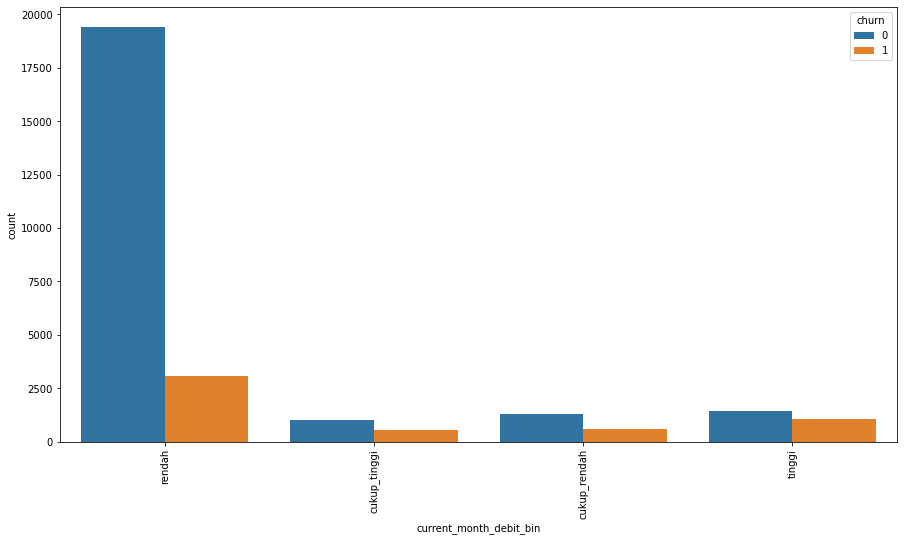

In [228]:
plt.figure(figsize=(15,8))
fig = sns.countplot(x= df["current_month_debit_bin"],hue=df["churn"])
fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
plt.show(fig)

In [229]:
pd.crosstab(index = [df[df["churn"]==1]["current_month_debit_bin"],df["churn"]],columns = "Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

,col_0,Jumlah
current_month_debit_bin,churn,
rendah,1,3071
tinggi,1,1041
cukup_rendah,1,603
cukup_tinggi,1,545


In [230]:
pd.crosstab(index = [df[df["churn"]==1]["current_month_debit_bin"],df["churn"]],columns = "%churn_1",normalize=True).sort_values(by="%churn_1",ascending=False).head(10)
## setelah dilakukan bining baru terlihat pengaruhnya
## rendah menjadi kategori yang memiliki presentase paling tinggu untuk perpindahan customer

,col_0,%churn_1
current_month_debit_bin,churn,
rendah,1,0.583840
tinggi,1,0.197909
cukup_rendah,1,0.114639
cukup_tinggi,1,0.103612


## PREVIOUS_MONTH_DEBIT

In [231]:
pd.crosstab(index = df["previous_month_debit"],columns = "Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

col_0,Jumlah
previous_month_debit,
0.19,280
0.59,274
0.47,274
0.17,266
0.57,265
0.10,264
0.33,263
0.46,263
0.49,262


In [232]:
pd.crosstab(index = [df[df["churn"]==1]["previous_month_debit"],df["churn"]],columns = "%churn_1",normalize=True).sort_values(by="%churn_1",ascending=False).head(10)

,col_0,%churn_1
previous_month_debit,churn,
0.41,1,0.008555
0.47,1,0.008365
0.37,1,0.007605
0.17,1,0.007605
0.61,1,0.007224
0.33,1,0.007224
0.27,1,0.007034
0.54,1,0.006844
0.63,1,0.006654


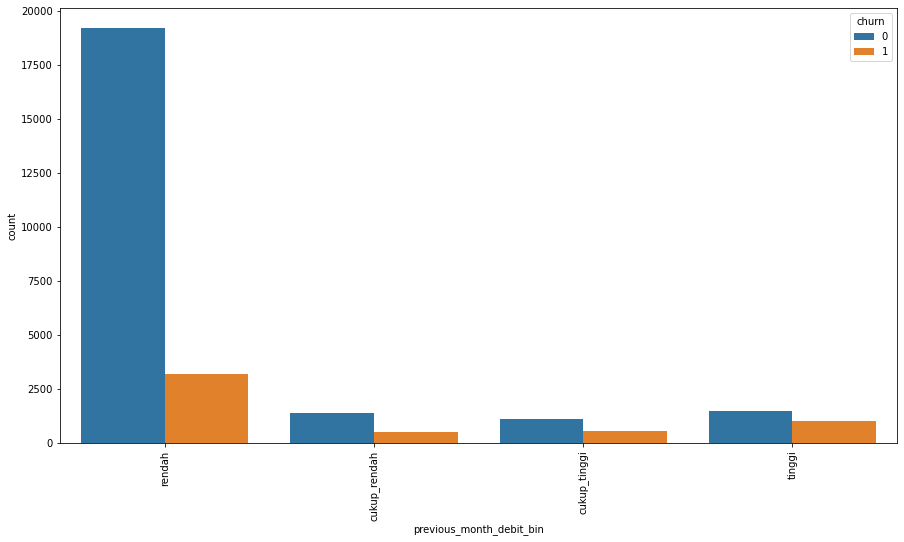

In [233]:
plt.figure(figsize=(15,8))
fig = sns.countplot(x= df["previous_month_debit_bin"],hue=df["churn"])
fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
plt.show(fig)

In [234]:
pd.crosstab(index = [df[df["churn"]==1]["previous_month_debit_bin"],df["churn"]],columns = "Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

,col_0,Jumlah
previous_month_debit_bin,churn,
rendah,1,3193
tinggi,1,1020
cukup_tinggi,1,544
cukup_rendah,1,503


In [235]:
pd.crosstab(index = [df[df["churn"]==1]["previous_month_debit_bin"],df["churn"]],columns = "%churn_1",normalize=True).sort_values(by="%churn_1",ascending=False).head(10)
## setelah dilakukan bining baru terlihat pengaruhnya
## rendah menjadi kategori yang memiliki presentase paling tinggu untuk perpindahan customer

,col_0,%churn_1
previous_month_debit_bin,churn,
rendah,1,0.607034
tinggi,1,0.193916
cukup_tinggi,1,0.103422
cukup_rendah,1,0.095627


## CURRENT_MONTH_BALANCE

In [236]:
pd.crosstab(index = df["current_month_balance"],columns = "Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

col_0,Jumlah
current_month_balance,
1429.14,4
1430.81,3
1817.62,3
1327.32,3
2154.28,3
1793.25,3
1549.92,3
2296.96,3
1533.61,3


In [237]:
pd.crosstab(index = [df[df["churn"]==1]["current_month_balance"],df["churn"]],columns = "%churn_1",normalize=True).sort_values(by="%churn_1",ascending=False).head(10)

,col_0,%churn_1
current_month_balance,churn,
5475.64,1,0.00038
5949.64,1,0.00038
4296.88,1,0.00038
786.77,1,0.00038
1157.50,1,0.00038
1572.36,1,0.00038
2291.37,1,0.00038
9.82,1,0.00038
1575.60,1,0.00038


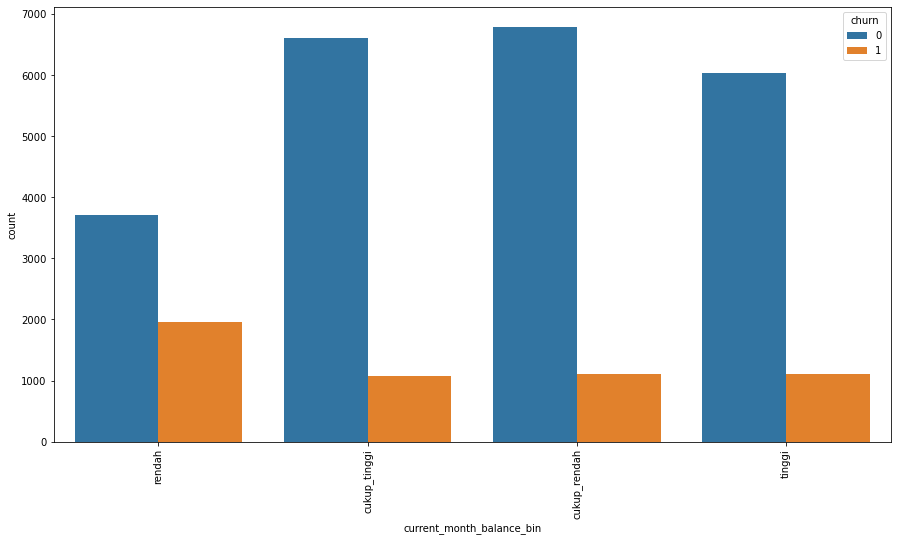

In [238]:
plt.figure(figsize=(15,8))
fig = sns.countplot(x= df["current_month_balance_bin"],hue=df["churn"])
fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
plt.show(fig)

In [239]:
pd.crosstab(index = [df[df["churn"]==1]["current_month_balance_bin"],df["churn"]],columns = "Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

,col_0,Jumlah
current_month_balance_bin,churn,
rendah,1,1965
cukup_rendah,1,1113
tinggi,1,1111
cukup_tinggi,1,1071


In [240]:
pd.crosstab(index = [df[df["churn"]==1]["current_month_balance_bin"],df["churn"]],columns = "%churn_1",normalize=True).sort_values(by="%churn_1",ascending=False).head(10)
## setelah dilakukan bining baru terlihat pengaruhnya
## rendah menjadi kategori yang memiliki presentase paling tinggu untuk perpindahan customer

,col_0,%churn_1
current_month_balance_bin,churn,
rendah,1,0.373574
cukup_rendah,1,0.211597
tinggi,1,0.211217
cukup_tinggi,1,0.203612


## PREVIOUS_MONTH_BALANCE

In [241]:
pd.crosstab(index = df["previous_month_balance"],columns = "Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

col_0,Jumlah
previous_month_balance,
3177.47,3
4635.31,3
1465.07,3
1429.14,3
2956.50,3
1556.59,3
1428.83,3
6180.47,2
2872.55,2


In [242]:
pd.crosstab(index = [df[df["churn"]==1]["previous_month_balance"],df["churn"]],columns = "%churn_1",normalize=True).sort_values(by="%churn_1",ascending=False).head(10)

,col_0,%churn_1
previous_month_balance,churn,
3500.49,1,0.00038
1824.04,1,0.00038
2798.91,1,0.00038
1464.51,1,0.00038
3207.41,1,0.00038
851.21,1,0.00038
2941.62,1,0.00038
18.18,1,0.00038
2476.96,1,0.00038


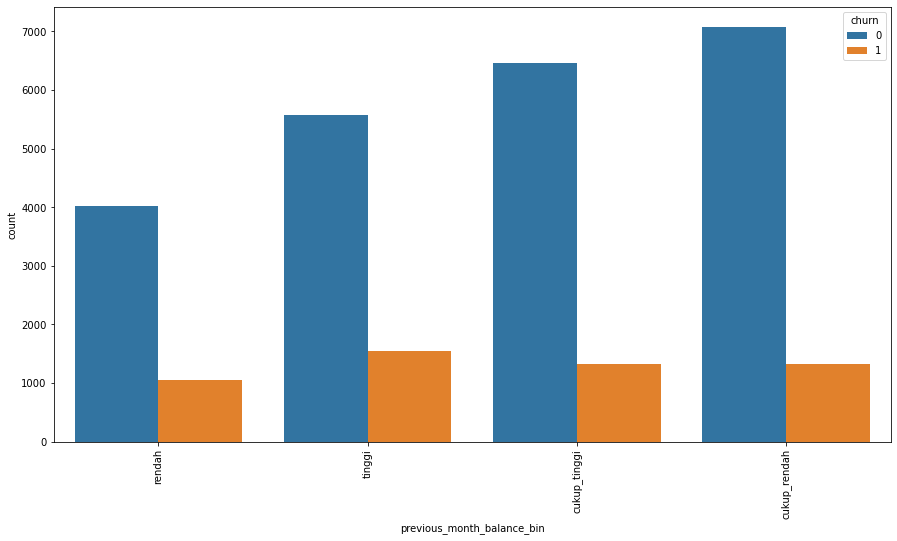

In [243]:
plt.figure(figsize=(15,8))
fig = sns.countplot(x= df["previous_month_balance_bin"],hue=df["churn"])
fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
plt.show(fig)

In [244]:
pd.crosstab(index = [df[df["churn"]==1]["previous_month_balance_bin"],df["churn"]],columns = "Jumlah").sort_values(by="Jumlah",ascending=False).head(10)

,col_0,Jumlah
previous_month_balance_bin,churn,
tinggi,1,1553
cukup_rendah,1,1333
cukup_tinggi,1,1329
rendah,1,1045


In [245]:
pd.crosstab(index = [df[df["churn"]==1]["previous_month_balance_bin"],df["churn"]],columns = "%churn_1",normalize=True).sort_values(by="%churn_1",ascending=False).head(10)
## setelah dilakukan bining baru terlihat pengaruhnya
## tinggi menjadi kategori yang memiliki presentase paling tinggu untuk perpindahan customer

,col_0,%churn_1
previous_month_balance_bin,churn,
tinggi,1,0.295247
cukup_rendah,1,0.253422
cukup_tinggi,1,0.252662
rendah,1,0.198669


# FEATURE SELECTION AND FEATURE ENGINEERING 

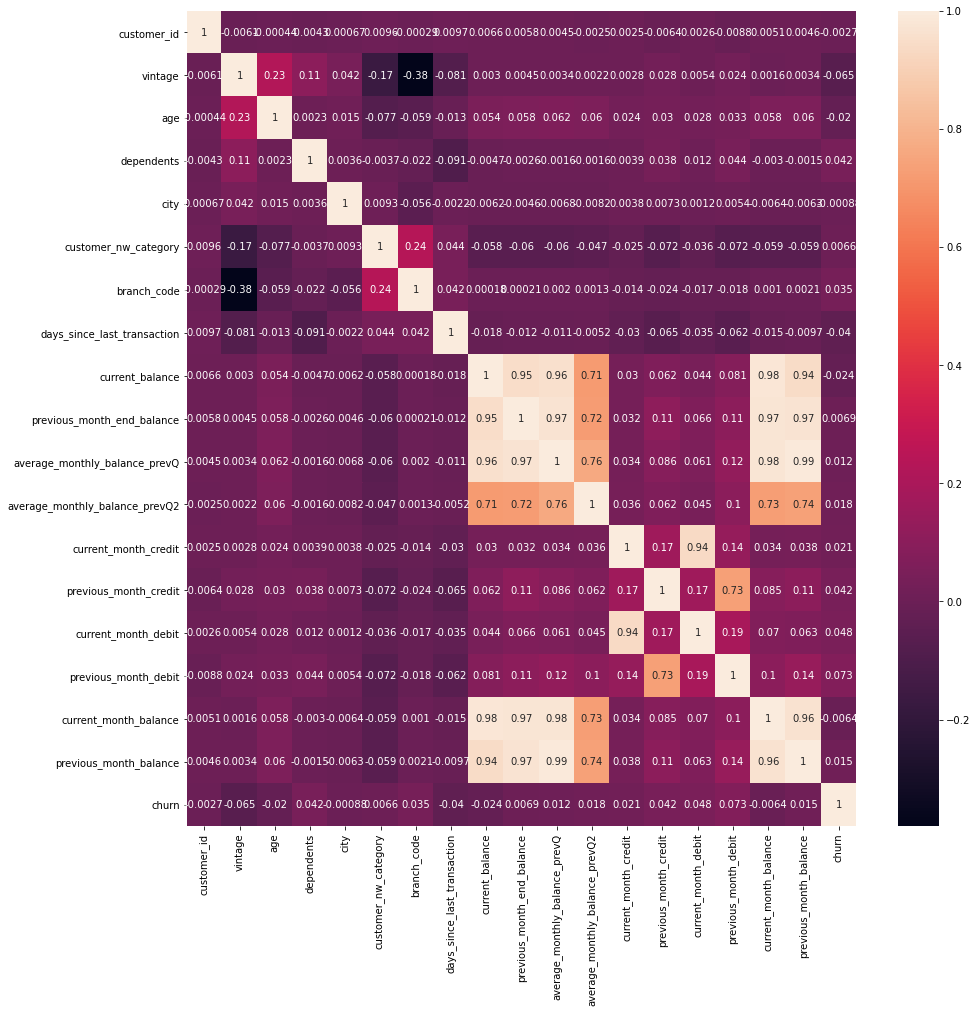

In [246]:
plt.figure(figsize=(15,15))
fig = sns.heatmap(df.corr(),annot=True)
fig.set_xticklabels(fig.get_xticklabels(),rotation=90)
plt.show(fig)

    Dari korelasi, tidak kelihatan karena semua memiliki korelasi rendah, jadi Feature selection akan dilakukan berdasarkan pemahaman pribadi dan EDA
<br>
     
    Kolom yang akan di drop :
        1. customer_id ==> karena merupakan unique number, menurut saya tidak mempunyai pengaruh yang signifikan
        2. vintage ==> dari EDA terlihat tidak memiliki pengaruh yang signifikan
        3. city ==> karena dari EDA terlihat pengaruhnya tidak terlalu signifikan juga, dibawah 20% terhadap perpindahan customer
        4. branch_code ==> hasil EDA dari branc_code, terlihat jelas tidak ada pengaruh yang signifikan
        5. day_since_last_transaction ==> tidak signifikan, dari EDA, terlihat pengaruhnya terhadap customer churn dibawah 20%
        6-10. previous_month_end_balance, average_monthly_balance_prevQ, average_monthly_balance_prevQ2,prev_month_balance,current_month_balance ==> akan diwakilkan oleh current_balance, dari Heatmap terlihat bahwa korelasinya sangat tinggi, sehingga kemungkinan besar mempiliki peran yang sama. Dan kenapa yang dipilih adalah current_balance, karena pada saat EDA, setelah dilakukan binning, current balance memiliki presentasi paling tinggi(pada kategori rendah)
        11. current_month_debit ==> memiliki korelasi tinggi dengan current_month_credit, sehingga kemungkinan besar perannya sama, jadi akan diambil salah satu, yaitu current_month_credit. Dan kenapa yang dipilih adalah current_month_credit, karena pada saat EDA, setelah dilakukan binning, current_month_credit memiliki presentasi paling tinggi(pada kategori rendah)
        12. previous_month_debit==> memiliki korelasi tinggi dengan previous_month_credit, sehingga kemunkginan besar perannya sama, jadi akan diambil salah satu, yaitu previous_month_credit. Dan kenapa yang dipilih adalah previous_month_credit, karena pada saat EDA, setelah dilakukan binning, current_month_credit memiliki presentasi paling tinggi(pada kategori rendah)

In [247]:
df = df.drop(columns=['customer_id', 'vintage', 'Age_bin','city', 'branch_code','days_since_last_transaction', 
                      'current_balance_bin','previous_month_end_balance', 'average_monthly_balance_prevQ',
                      'average_monthly_balance_prevQ2', 'current_month_credit_bin','previous_month_credit_bin', 
                      'current_month_debit', 'previous_month_debit', "previous_month_balance" , 
                      'current_month_balance','current_month_balance_bin', 'previous_month_balance_bin', 
                      'previous_month_end_balance_bin','average_monthly_balance_prevQ_bin',
                      'average_monthly_balance_prevQ2_bin','current_month_debit_bin', 'previous_month_debit_bin'])

In [248]:
df.head()

,age,gender,dependents,occupation,customer_nw_category,current_balance,current_month_credit,previous_month_credit,churn
0,66,Male,0,self_employed,2,1458.71,0.20,0.20,0
1,35,Male,0,self_employed,2,5390.37,0.56,0.56,0
2,31,Male,0,salaried,2,3913.16,0.61,0.61,0
3,90,Male,0,self_employed,2,2291.91,0.47,0.47,1
4,42,Male,1,self_employed,3,927.72,0.33,714.61,1


In [249]:
df.to_csv("./Datasets/df_churn.csv")

## ONEHOT ENCODING

In [250]:
# # df = pd.get_dummies(data=df,columns = ['gender','occupation','Age_bin'],prefix_sep='_')
# df = pd.get_dummies(data=df,columns = ['occupation'],prefix_sep='_')
df = pd.get_dummies(data=df,columns = ['gender'],prefix_sep='_')

# LABEL ENCODING

In [251]:
def recat_nw(x):
    '''
    recat_nw = membuat kategori ulang pada customer net nowrth category, karena aslinya descending,
    mau dibuat ascending.
    x = setiap isi dari kolom yang akan di apply(kolom "customer_nw_category")
    '''
    if x == 3 :
        return 0
    elif x == 2 :
        return 1
    elif x == 1:
        return 3

In [252]:
# df["gender"] = df["gender"].map({
#     "Female" : 0,
#     "Male" : 1
# }) 
df["occupation"] = df["occupation"].map({
    "student" : 0,
    "salaried" : 1,
    "self_employed" : 2,
    "company" : 3,
    "retired" : 4
}) 
# df["current_balance_bin"] = df["current_balance_bin"].map({
#     "rendah" : 0,
#     "cukup_rendah" : 1,
#     "cukup_tinggi" : 2,
#     "tinggi" : 3
# }) 
# df["current_month_credit_bin"] = df["current_month_credit_bin"].map({
#     "rendah" : 0,
#     "cukup_rendah" : 1,
#     "cukup_tinggi" : 2,
#     "tinggi" : 3
# }) 
# df["previous_month_credit_bin"] = df["previous_month_credit_bin"].map({
#     "rendah" : 0,
#     "cukup_rendah" : 1,
#     "cukup_tinggi" : 2,
#     "tinggi" : 3
# }) 
# df["current_month_balance_bin"] = df["current_month_balance_bin"].map({
#     "rendah" : 0,
#     "cukup_rendah" : 1,
#     "cukup_tinggi" : 2,
#     "tinggi" : 3
# }) 
# df["previous_month_balance_bin"] = df["previous_month_balance_bin"].map({
#     "rendah" : 0,
#     "cukup_rendah" : 1,
#     "cukup_tinggi" : 2,
#     "tinggi" : 3
# }) 
df["customer_nw_category"] = df["customer_nw_category"].apply(recat_nw)

In [253]:
df.head()

,age,dependents,occupation,customer_nw_category,current_balance,current_month_credit,previous_month_credit,churn,gender_Female,gender_Male
0,66,0,2,1,1458.71,0.20,0.20,0,0,1
1,35,0,2,1,5390.37,0.56,0.56,0,0,1
2,31,0,1,1,3913.16,0.61,0.61,0,0,1
3,90,0,2,1,2291.91,0.47,0.47,1,0,1
4,42,1,2,0,927.72,0.33,714.61,1,0,1


In [255]:
# df.to_csv("df_clean.csv")
# # df.to_csv("./Datasets/df_clean.csv")
# df.to_csv("./Datasets/df_new_2.csv")
# df.to_csv("./Datasets/df_onehotx.csv")
df.to_csv("./Datasets/df_ohgender.csv")